# Preliminary Info

**Model - SimpleAvgEmbed :** Simply takes the average of all tokens' embeddings inside a cell and passes to the FF Linear Layer for a Naive binary classification.

**Data Hierarchy Train/Val/Test = (80-10-10) : big > medium > small > tiny > micro > teeny**
- **big** (800 - 100 - 100)
- **medium** (400 - 50 - 50)
- **small** (200 - 25 - 25)
- **tiny** (100 - 12 - 12)
- **micro** (50 - 6 - 6)
- **teeny** (25 - 3 - 3)


# Setup

## Imports

In [6]:
# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import sys
import os

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import the utilities and the dataloader
from utils import selfutil, trainutil, inferutil
from classes import SpreadsheetDataLoader, SimpleAvgEmbed

# Now reload the modules to ensure they are up-to-date
importlib.reload(selfutil)
importlib.reload(trainutil)
importlib.reload(inferutil)
importlib.reload(SpreadsheetDataLoader)
importlib.reload(SimpleAvgEmbed)

# Import the funcs needed from utils
from utils.selfutil import get_vocab, get_fileList, create_embeddings
from utils.trainutil import train_model
from utils.inferutil import infer_one, infer_full

# Import the SpreadsheetDataLoader class
from classes.SpreadsheetDataLoader import SpreadsheetDataLoader
from classes.SimpleAvgEmbed import SimpleAvgEmbed

# Other regular imports
import torch.nn as nn
import torch
from tqdm import tqdm
import gc
import os
import pandas as pd
import math
import time
import numpy as np
import random

# Setup device as a global constant
devstr = "cuda"  # Change to "cpu" or "mps" as needed
gpu = False if (devstr == 'cpu') else True

# Determine the device to use
if devstr.startswith('cuda') and torch.cuda.is_available():
    DEVICE = torch.device(devstr)
elif devstr.startswith('mps') and torch.backends.mps.is_available():
    DEVICE = torch.device(devstr)
else:
    DEVICE = 'cpu'  # Default to CPU if none of the above are available

# Determine the global count of threads to use in parallel operations
THREADS = 1.1

print(DEVICE)

cuda


## Vocab/Embeddings

In [4]:
# Set the directory containing the spreadsheets for vocab training
vocab_dir = '../../data/farzan/manual_train/'

# Get the vocabulary object and embeddings
spreadsheet_vocab = get_vocab(vocab_dir, 150000, space = True, case = 'both', threads = THREADS)
spreadsheet_wvs = create_embeddings(spreadsheet_vocab)

Getting Vocab: 100%|████████████████████████████| 40/40 [00:02<00:00, 14.68it/s]


40(P) = 40(G) + 0(E)
Unique Tokens: 5593
Vocab Size: 5597


Creating Word Embeddings: 100%|██████████| 5597/5597 [00:00<00:00, 67419.45it/s]

Word Embeddings Shape: torch.Size([5597, 50])


## File List and DataLoaders

In [5]:
# Define the directories
train_dir = '../../data/farzan/manual_train/'
val_dir = '../../data/farzan/manual_val/'
test_dir = '../../data/farzan/manual_test/'

# Get the files for each directory
train_files,_ = get_fileList(train_dir)
val_files,_ = get_fileList(val_dir)
test_files,_ = get_fileList(test_dir)

# Print the number of files in each list
print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}")

# Decide max_rows, max_cols and num_tokens defaults 100, 100, 32
max_rows = 100
max_cols = 100
num_tokens = 32

# Create the data loaders
train_loader = SpreadsheetDataLoader(train_files, spreadsheet_vocab, max_rows, max_cols, num_tokens, threads = THREADS)
val_loader = SpreadsheetDataLoader(val_files, spreadsheet_vocab, max_rows, max_cols, num_tokens, threads = THREADS)
test_loader = SpreadsheetDataLoader(test_files, spreadsheet_vocab, max_rows, max_cols, num_tokens, threads = THREADS)

Train files: 40
Validation files: 5
Test files: 5


Processing files: 100%|████████████████████████| 40/40 [00:00<00:00, 261.50it/s]



40(P) = 40(G) + 0(E)


Processing files: 100%|█████████████████████████| 5/5 [00:00<00:00, 8905.10it/s]



5(P) = 5(G) + 0(E)


Processing files: 100%|█████████████████████████| 5/5 [00:00<00:00, 6243.38it/s]



5(P) = 5(G) + 0(E)


# Model Training

## Define the model

In [4]:
# Define the untrained model and move it to the device
untrained_model = SimpleAvgEmbed(spreadsheet_wvs).to(DEVICE)
print(untrained_model)


SimpleAvgEmbed(
  (_embed): Embedding(5597, 50)
  (_drop): Dropout(p=0.05, inplace=False)
  (_pred): Linear(in_features=50, out_features=1, bias=True)
)


In [5]:
# # Get a single batch to test with 
# check_loader = torch.utils.data.DataLoader(train_loader, batch_size=5, shuffle=False)
# 
# # Get one batch from the DataLoader
# batch = next(iter(check_loader))
# 
# # Move the extracted x_tok to gpu
# exfile = batch['x_tok'].to(DEVICE)
# 
# # Define model
# untrained_model = SimpleAvgEmbed(spreadsheet_wvs).to(DEVICE)
# 
# # Observe the model
# out = untrained_model.forward(exfile)
# 
# print(f'Model Structure:\n{untrained_model}')
# print(out.shape)

# Training Loop

In [6]:
# Define the model training parameters
trained_model = train_model(
    model = untrained_model,
    train_data = train_loader, 
    val_data = val_loader, 
    DEVICE = DEVICE, 
    batch_size = 40, 
    lr = 1e-1, 
    mu = 0.25, 
    max_epochs = 20, 
    patience = 3, 
    save_int = 0, 
    save_dir = '../models/', 
    save_name = 'simpleavgembed_big'
)

Epoch 0


Validation Processing: 100%|█████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


Train Loss: 1.9478099346160889, Perplexity: 1.0000194782890455
Val Loss: 0.40156853199005127, Perplexity: 1.0000040156933827


Epoch 1


Validation Processing: 100%|█████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Train Loss: 0.41105982661247253, Perplexity: 1.0000041106067146
Val Loss: 0.4607200622558594, Perplexity: 1.0000046072112356


Epoch 2


Validation Processing: 100%|█████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


Train Loss: 0.4518980383872986, Perplexity: 1.0000045189905944
Val Loss: 0.3322182595729828, Perplexity: 1.0000033221881142


Epoch 3


Validation Processing: 100%|█████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


Train Loss: 0.332912802696228, Perplexity: 1.0000033291335686
Val Loss: 0.38328781723976135, Perplexity: 1.0000038328855179


Epoch 4


Validation Processing: 100%|█████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


Train Loss: 0.37607210874557495, Perplexity: 1.0000037607281589
Val Loss: 0.3037581443786621, Perplexity: 1.0000030375860574


Epoch 5


Validation Processing: 100%|█████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Train Loss: 0.30402377247810364, Perplexity: 1.0000030402423463
Val Loss: 0.33570441603660583, Perplexity: 1.0000033570497953


Epoch 6


Validation Processing: 100%|█████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Train Loss: 0.3308291435241699, Perplexity: 1.0000033082969075
Val Loss: 0.28606557846069336, Perplexity: 1.0000028606598763


Epoch 7


Validation Processing: 100%|█████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Train Loss: 0.2883188724517822, Perplexity: 1.0000028831928809
Val Loss: 0.3072390854358673, Perplexity: 1.0000030723955742


Epoch 8


Validation Processing: 100%|█████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Train Loss: 0.30449220538139343, Perplexity: 1.0000030449266897
Val Loss: 0.26826056838035583, Perplexity: 1.000002682609282


Epoch 9


Validation Processing: 100%|█████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Train Loss: 0.2713429927825928, Perplexity: 1.0000027134336091
Val Loss: 0.2819552719593048, Perplexity: 1.0000028195566946


Epoch 10


Validation Processing: 100%|█████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


Train Loss: 0.2814452052116394, Perplexity: 1.0000028144560127
Val Loss: 0.2514232397079468, Perplexity: 1.0000025142355577


Epoch 11


Validation Processing: 100%|█████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Train Loss: 0.25670942664146423, Perplexity: 1.0000025670975614
Val Loss: 0.25927436351776123, Perplexity: 1.0000025927469964


Epoch 12


Validation Processing: 100%|█████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Train Loss: 0.26101893186569214, Perplexity: 1.0000026101927253
Val Loss: 0.23520343005657196, Perplexity: 1.0000023520370667


Epoch 13


Validation Processing: 100%|█████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Train Loss: 0.24389076232910156, Perplexity: 1.0000024389105975
Val Loss: 0.2387886643409729, Perplexity: 1.0000023878894944


Epoch 14


Validation Processing: 100%|█████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Train Loss: 0.24277667701244354, Perplexity: 1.0000024277697173
Val Loss: 0.21964794397354126, Perplexity: 1.000002196481852


Epoch 15


Validation Processing: 100%|█████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


Train Loss: 0.2287033200263977, Perplexity: 1.0000022870358156
Val Loss: 0.21942779421806335, Perplexity: 1.0000021942803496


Epoch 16


Validation Processing: 100%|█████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Train Loss: 0.22525370121002197, Perplexity: 1.000002252539549
Val Loss: 0.20236167311668396, Perplexity: 1.0000020236187788


Epoch 17


Validation Processing: 100%|█████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Train Loss: 0.2120811641216278, Perplexity: 1.00000212081389
Val Loss: 0.2011662870645523, Perplexity: 1.000002011664894


Epoch 18


Validation Processing: 100%|█████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Train Loss: 0.208812415599823, Perplexity: 1.000002088126336
Val Loss: 0.1858055591583252, Perplexity: 1.0000018580573178


Epoch 19


Validation Processing: 100%|█████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]

Train Loss: 0.1971093714237213, Perplexity: 1.000001971095657
Val Loss: 0.18266227841377258, Perplexity: 1.0000018266244524



TRAINING DONE at epoch 19, best epoch 19
Train Loss = 0.1971093714237213, Perplexity = 1.000001971095657
Val Loss = 0.18266227841377258, Perplexity = 1.0000018266244524


# Evaluation

## Single File for Train/Val/Test


Filename: ../../data/farzan/manual_train/Harassment-Bullying-on-basis-of-race_reported.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
(6,1): 0.892705
(5,3): 0.933426
(5,22): 0.934748
(4,11): 0.938002
(1,1): 0.940036
(5,18): 0.940209
(4,5): 0.941213
(3,1): 0.945339
(5,4): 0.948103
(3,2): 0.958191
(3,23): 0.958953
(3,3): 0.959797
(4,9): 0.972226
(4,15): 0.974194
(3,21): 0.977453
(3,24): 0.977521
(4,3): 0.980387
(4,7): 0.981171
(4,13): 0.988189
(3,17): 0.990100
(3,19): 0.994623

NB to B ratio: Predicted = 9930:70 | Actual = 9930:70
Accuracy: 99.98% | Precision: 98.57% | Recall: 98.57% | F1-Score: 0.99



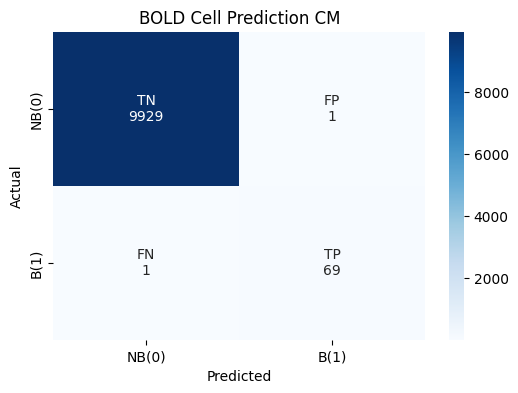


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
infer_one(
    trained_model=trained_model,
    infer_loader=train_loader,
    loc=0,
    threshold=0.93,
    condition='>',
    disp_max=True,
    device=DEVICE
)



Filename: ../../data/farzan/manual_val/advanced-placement-mathematics-enrollment.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
(5,3): 0.933426
(5,18): 0.934748
(4,11): 0.938002
(4,5): 0.941213
(3,1): 0.945339
(5,4): 0.948103
(3,2): 0.958191
(3,21): 0.958953
(3,3): 0.959797
(4,9): 0.972226
(4,15): 0.974194
(3,19): 0.977453
(3,22): 0.977521
(1,1): 0.979895
(4,3): 0.980387
(4,7): 0.981171
(4,13): 0.988189
(3,17): 0.991742

NB to B ratio: Predicted = 9936:64 | Actual = 9937:63
Accuracy: 99.99% | Precision: 98.44% | Recall: 100.00% | F1-Score: 0.99



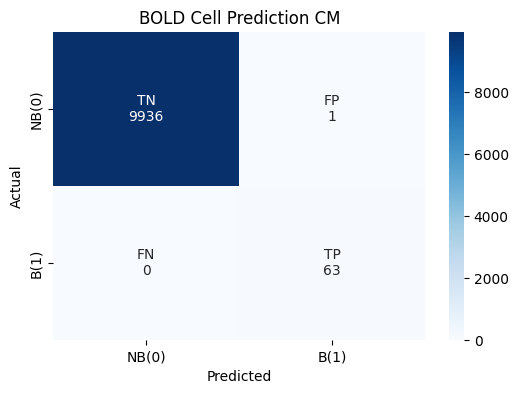


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0


In [11]:
infer_one(
    trained_model=trained_model,
    infer_loader=val_loader,
    loc=0,
    threshold=0.93,
    condition='>',
    disp_max=True,
    device=DEVICE
)



Filename: ../../data/farzan/manual_test/dlportfolio-by-school-type.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(4,2): 0.930328
(4,10): 0.933677
(4,8): 0.934632
(19,0): 0.935075
(6,0): 0.935445
(15,0): 0.937269
(6,1): 0.937700
(8,1): 0.938457
(7,1): 0.938763
(11,0): 0.939210
(7,0): 0.939546
(9,1): 0.941269
(4,4): 0.941337
(4,6): 0.946317
(5,0): 0.969817
(5,3): 0.984149
(0,0): 0.985735
(5,2): 0.995059
(5,4): 0.995882

NB to B ratio: Predicted = 9935:65 | Actual = 9936:64
Accuracy: 99.99% | Precision: 98.46% | Recall: 100.00% | F1-Score: 0.99



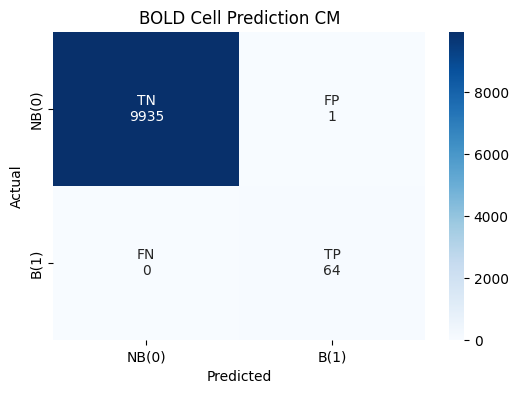


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11
0,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11
0,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0


In [13]:
infer_one(
    trained_model=trained_model,
    infer_loader=test_loader,
    loc=0,
    threshold=0.93,
    condition='>',
    disp_max=True,
    device=DEVICE
)


## Full Inference

Batch Inference: 100%|███████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49619:381 | Actual = 49606:394
Accuracy: 99.95% | Precision: 98.43% | Recall: 95.18% | F1-Score: 0.97



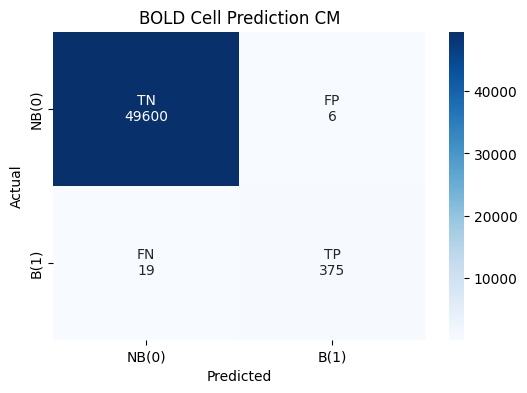

In [14]:
infer_full(
    trained_model=trained_model,
    infer_loader=test_loader,
    batch_size=40,
    threshold=0.93,
    device=DEVICE
)


Batch Inference: 100%|███████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49598:402 | Actual = 49602:398
Accuracy: 99.99% | Precision: 98.76% | Recall: 99.75% | F1-Score: 0.99



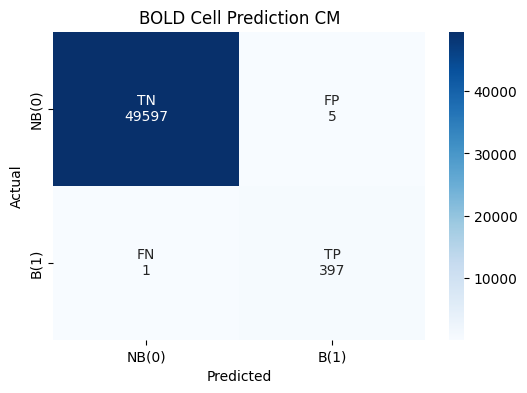

In [15]:
infer_full(
    trained_model=trained_model,
    infer_loader=val_loader,
    batch_size=5,
    threshold=0.93,
    device=DEVICE
)


Batch Inference: 100%|███████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49619:381 | Actual = 49606:394
Accuracy: 99.95% | Precision: 98.43% | Recall: 95.18% | F1-Score: 0.97



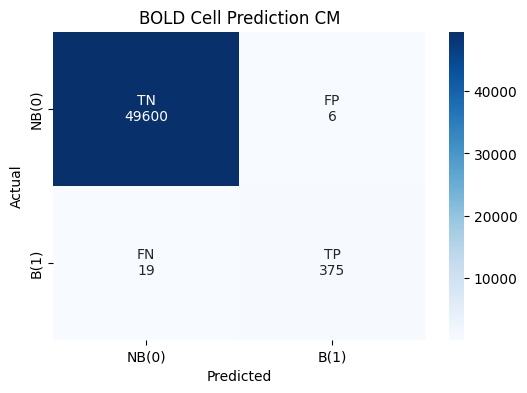

In [16]:
infer_full(
    trained_model=trained_model,
    infer_loader=test_loader,
    batch_size=5,
    threshold=0.93,
    device=DEVICE
)
